# 05 - Hyperparameter Tuning (classification)

Objectif : optimiser les modèles de classification pour la seule cible **exam passed** (priorité rappel de la classe "fail") via GridSearchCV, RandomizedSearchCV et Optuna, comparer aux baselines et sauvegarder le meilleur modèle.

In [1]:
#imports
import pandas as pd
import numpy as np
from pathlib import Path
from types import SimpleNamespace

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import optuna

c:\Users\nicol\anaconda3\envs\Data\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Charger et préparer les données
- Chargement `data/processed/train.csv` et `test.csv`
- Drop des colonnes d'index sauvegardées
- Cible unique : `exam passed`; features catégorielles socio-démo
- Préprocessing : OneHotEncoder pour toutes les features cat (éviter l'ordinalité)

In [2]:
# Imports & data loading

sns.set_style("whitegrid")
RANDOM_STATE = 42
CV_SPLITS = 5

# Paths
train_path = Path('..') / 'data' / 'processed' / 'train.csv'
test_path = Path('..') / 'data' / 'processed' / 'test.csv'

for p in [train_path, test_path]:
    assert p.exists(), f"Missing file: {p}"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Drop stray index columns
cols_to_drop = [c for c in train_df.columns if c.startswith('Unnamed') or c == '']
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

base_cols = [
    "gender",
    "race/ethnicity",
    "parental level of education",
    "lunch",
    "test preparation course",
]

tasks = {
    "language": {"target": "language passed", "features": base_cols},
    "math": {"target": "math passed", "features": base_cols},
    "exam": {"target": "exam passed", "features": base_cols},
}

# Build splits per task (no split train/val here because CV handles it)
data_splits = {}
for name, spec in tasks.items():
    X_train = train_df[spec["features"]]
    y_train = train_df[spec["target"]]
    X_test = test_df[spec["features"]]
    y_test = test_df[spec["target"]]
    data_splits[name] = {"X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test}

categorical_cols = base_cols
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
], remainder="drop")

recall_fail_scorer = make_scorer(recall_score, pos_label=0)
scoring = {
    "recall_fail": recall_fail_scorer,
    "f1": "f1",
    "accuracy": "accuracy",
    "roc_auc": "roc_auc",
}

cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)


## 2. Définir le modèle de base
Baseline : pipelines simples (LogReg, RF, GBoost, XGB, LGBM, Linear SVM calibré) avec pondération de classe, sur la seule tâche `exam`. Mesure principale : recall_fail (classe 0).

In [3]:
# Baselines (option: skip if pretrained models are available)
USE_PRETRAINED_EXAM = True


def make_models_for_task(y_train):
    n_fail = max((y_train == 0).sum(), 1)
    n_pass = max((y_train == 1).sum(), 1)
    fail_weight = n_pass / n_fail
    scale_pos_weight = n_fail / n_pass

    return {
        "log_reg": Pipeline([
            ("prep", preprocessor),
            ("clf", LogisticRegression(max_iter=1000, n_jobs=-1, class_weight="balanced", solver="lbfgs")),
        ]),
        "rf": Pipeline([
            ("prep", preprocessor),
            ("clf", RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced")),
        ]),
        "gboost": Pipeline([
            ("prep", preprocessor),
            ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE)),
        ]),
        "xgb": Pipeline([
            ("prep", preprocessor),
            ("clf", XGBClassifier(
                n_estimators=400,
                max_depth=4,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                eval_metric="logloss",
                random_state=RANDOM_STATE,
                n_jobs=-1,
                scale_pos_weight=scale_pos_weight,
            )),
        ]),
        "lgbm": Pipeline([
            ("prep", preprocessor),
            ("clf", LGBMClassifier(
                n_estimators=400,
                max_depth=-1,
                num_leaves=31,
                learning_rate=0.05,
                subsample=0.9,
                colsample_bytree=0.9,
                random_state=RANDOM_STATE,
                class_weight={0: fail_weight, 1: 1.0},
            )),
        ]),
        "linear_svm": Pipeline([
            ("prep", preprocessor),
            ("clf", CalibratedClassifierCV(
                estimator=LinearSVC(class_weight="balanced"),
                cv=3,
                n_jobs=-1,
            )),
        ]),
    }


def cv_eval(model, X, y):
    cv_res = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False,
    )
    return {k.replace("test_", ""): np.mean(v) for k, v in cv_res.items() if k.startswith("test_")}

# Baseline CV (exam only, unless pretrained used)
baseline_rows = []
baseline_results = {}
models_by_task = {}
for task, split in data_splits.items():
    if USE_PRETRAINED_EXAM:
        continue
    models = make_models_for_task(split["y_train"])
    models_by_task[task] = models
    baseline_results[task] = {}
    for name, model in models.items():
        res = cv_eval(model, split["X_train"], split["y_train"])
        baseline_results[task][name] = res
        baseline_rows.append({"task": task, "model": name, **res})

if baseline_rows:
    baseline_df = pd.DataFrame(baseline_rows).sort_values(["task", "recall_fail"], ascending=[True, False])
else:
    baseline_df = pd.DataFrame(columns=["task", "model", "recall_fail", "f1", "accuracy", "roc_auc"])

baseline_df.head()

,task,model,recall_fail,f1,accuracy,roc_auc


## 3. GridSearchCV (espace restreint, explicite)
- Modèle ciblé : XGBClassifier
- Justification : profondeur modérée, lr faible, subsample/colsample pour limiter l’overfit, scale_pos_weight dérivé du ratio classes.
- Param_grid (exemple) :
  - max_depth: [3, 4, 5]
  - learning_rate: [0.02, 0.05, 0.1]
  - n_estimators: [200, 400, 600]
  - subsample: [0.7, 0.9]
  - colsample_bytree: [0.7, 0.9]
  - scale_pos_weight: [ratio, ratio*0.7, ratio*1.3] (ratio = n_fail/n_pass)

## 3.1 Utiliser les modèles exam déjà entraînés (04b)
Si disponibles dans `models/exam_*.joblib`, on les charge pour éviter de réentraîner la baseline exam.

In [4]:
# Charger les modèles exam déjà entraînés (si présents dans models/exam_*.joblib)
exam_split = data_splits["exam"]
pretrained_exam_rows = []
models_dir = Path("..") / "models" / "classification"
if USE_PRETRAINED_EXAM and models_dir.exists():
    for path in models_dir.glob("exam_*.joblib"):
        model_name = path.stem.replace("exam_", "")
        model = joblib.load(path)
        preds = model.predict(exam_split["X_test"])
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(exam_split["X_test"])[:, 1]
            auc = roc_auc_score(exam_split["y_test"], proba)
        elif hasattr(model, "decision_function"):
            proba = model.decision_function(exam_split["X_test"])
            auc = roc_auc_score(exam_split["y_test"], proba)
        else:
            proba = None
            auc = np.nan
        pretrained_exam_rows.append(
            {
                "task": "exam",
                "model": model_name,
                "accuracy": accuracy_score(exam_split["y_test"], preds),
                "f1": f1_score(exam_split["y_test"], preds),
                "recall_fail": recall_score(exam_split["y_test"], preds, pos_label=0),
                "roc_auc": auc,
            }
        )

pretrained_exam_df = pd.DataFrame(pretrained_exam_rows).sort_values("recall_fail", ascending=False)
pretrained_exam_df.head()

c:\Users\nicol\anaconda3\envs\Data\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\nicol\anaconda3\envs\Data\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\nicol\anaconda3\envs\Data\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nicol\anaconda3\envs\Data\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_i

,task,model,accuracy,f1,recall_fail,roc_auc
1,exam,log_reg,0.595,0.672065,0.654545,0.682821
2,exam,xgb,0.615,0.698039,0.618182,0.646583
0,exam,lgbm,0.590,0.674603,0.600000,0.629655


In [5]:
# Grid search XGB (task exam)
exam_split = data_splits["exam"]
X_exam, y_exam = exam_split["X_train"], exam_split["y_train"]
n_fail = max((y_exam == 0).sum(), 1)
n_pass = max((y_exam == 1).sum(), 1)
fail_pass_ratio = n_fail / n_pass

xgb_base = Pipeline([
    ("prep", preprocessor),
    (
        "clf",
        XGBClassifier(
            random_state=RANDOM_STATE,
            eval_metric="logloss",
            n_jobs=-1,
            use_label_encoder=False,
            scale_pos_weight=fail_pass_ratio,
        ),
    ),
])

xgb_param_grid = {
    "clf__max_depth": [3, 4, 5],
    "clf__learning_rate": [0.02, 0.05, 0.1],
    "clf__n_estimators": [200, 400, 600],
    "clf__subsample": [0.7, 0.9],
    "clf__colsample_bytree": [0.7, 0.9],
    "clf__scale_pos_weight": [fail_pass_ratio * f for f in [0.7, 1.0, 1.3]],
}

grid_xgb = GridSearchCV(
    xgb_base,
    xgb_param_grid,
    scoring=scoring,
    refit="recall_fail",
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

grid_xgb.fit(X_exam, y_exam)

def extract_best_scores(search):
    idx = search.best_index_
    res = search.cv_results_
    return {
        "recall_fail": res["mean_test_recall_fail"][idx],
        "f1": res["mean_test_f1"][idx],
        "accuracy": res["mean_test_accuracy"][idx],
        "roc_auc": res["mean_test_roc_auc"][idx],
    }

xgb_grid_scores = extract_best_scores(grid_xgb)
pd.DataFrame([
    {"model": "xgb_grid", **xgb_grid_scores, **{k.replace("clf__", "param_"): v for k, v in grid_xgb.best_params_.items()}},
])

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\nicol\anaconda3\envs\Data\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:40:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,model,recall_fail,f1,accuracy,roc_auc,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_scale_pos_weight,param_subsample
0,xgb_grid,0.807879,0.616588,0.57125,0.710984,0.9,0.02,3,200,0.272222,0.9


## 4. RandomizedSearchCV (espace plus large)
- Modèle ciblé : LGBMClassifier
- Justification : balayage plus large via distributions continues pour lr/subsample/colsample et discrètes pour num_leaves/n_estimators.
- n_iter modéré pour rester raisonnable en temps.

In [8]:
# Randomized search LGBM (task exam)
fail_weight = n_pass / n_fail

lgbm_base = Pipeline([
    ("prep", preprocessor),
    (
        "clf",
        LGBMClassifier(
            random_state=RANDOM_STATE,
            class_weight={0: fail_weight, 1: 1.0},
            n_jobs=-1,
        ),
    ),
])

lgbm_param_dist = {
    "clf__num_leaves": randint(15, 64),
    "clf__max_depth": [-1, 4, 6, 8],
    "clf__learning_rate": uniform(0.02, 0.15),
    "clf__n_estimators": randint(200, 601),
    "clf__subsample": uniform(0.6, 0.4),
    "clf__colsample_bytree": uniform(0.6, 0.4),
}

rand_lgbm = RandomizedSearchCV(
    lgbm_base,
    lgbm_param_dist,
    n_iter=10,
    scoring=scoring,
    refit="recall_fail",
    cv=cv,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1,
)

rand_lgbm.fit(X_exam, y_exam)

lgbm_rand_scores = extract_best_scores(rand_lgbm)
pd.DataFrame([
    {"model": "lgbm_random", **lgbm_rand_scores, **{k.replace("clf__", "param_"): v for k, v in rand_lgbm.best_params_.items()}},
])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 576, number of negative: 224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

,model,recall_fail,f1,accuracy,roc_auc,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,param_subsample
0,lgbm_random,0.585152,0.728651,0.64375,0.675257,0.673362,0.065636,4,452,58,0.609225


## 5. Optuna (TPE, priorité recall_fail)
- TPE sampler avec graine fixe.
- Même préprocessing OneHot; cible = exam.
- Objectif : maximiser le recall de la classe "fail" via validation croisée.
- Espace : profondeur, lr, n_estimators, subsample, colsample, min_child_weight.

In [9]:
# Optuna search (XGB) on exam
exam_split = data_splits["exam"]
X_exam, y_exam = exam_split["X_train"], exam_split["y_train"]
n_fail = max((y_exam == 0).sum(), 1)
n_pass = max((y_exam == 1).sum(), 1)
fail_pass_ratio = n_fail / n_pass


def build_xgb_with_params(params):
    return Pipeline(
        [
            ("prep", preprocessor),
            (
                "clf",
                XGBClassifier(
                    random_state=RANDOM_STATE,
                    eval_metric="logloss",
                    n_jobs=-1,
                    use_label_encoder=False,
                    scale_pos_weight=fail_pass_ratio,
                    **params,
                ),
            ),
        ]
    )


def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.15, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 200, 700),
        "subsample": trial.suggest_float("subsample", 0.6, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.95),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.5, 5.0),
    }
    model = build_xgb_with_params(params)
    cv_res = cross_validate(
        model,
        X_exam,
        y_exam,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False,
    )
    return np.mean(cv_res["test_recall_fail"])


study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=25, show_progress_bar=False)

optuna_best_params = study.best_params
optuna_best_recall = study.best_value
optuna_best_estimator = build_xgb_with_params(optuna_best_params)

# CV metrics on best estimator (for comparison table)
optuna_cv_scores = cv_eval(optuna_best_estimator, X_exam, y_exam)

# Fit best estimator on full exam train for downstream test eval
optuna_best_estimator.fit(X_exam, y_exam)

pd.DataFrame([
    {"model": "optuna_xgb", **optuna_cv_scores, **{f"param_{k}": v for k, v in optuna_best_params.items()}},
])

[I 2026-01-07 14:44:38,276] A new study created in memory with name: no-name-2a7dacf6-e593-4403-b4a2-ec0839f13aff
[I 2026-01-07 14:44:38,682] Trial 0 finished with value: 0.576060606060606 and parameters: {'max_depth': 4, 'learning_rate': 0.1358198535217987, 'n_estimators': 566, 'subsample': 0.8095304694689628, 'colsample_bytree': 0.6546065241548528, 'min_child_weight': 1.201975341512912}. Best is trial 0 with value: 0.576060606060606.
[I 2026-01-07 14:44:38,947] Trial 1 finished with value: 0.5984848484848484 and parameters: {'max_depth': 3, 'learning_rate': 0.11454791487656053, 'n_estimators': 501, 'subsample': 0.8478254022286159, 'colsample_bytree': 0.6072045730035308, 'min_child_weight': 4.864594334728975}. Best is trial 1 with value: 0.5984848484848484.
[I 2026-01-07 14:44:39,190] Trial 2 finished with value: 0.5895959595959597 and parameters: {'max_depth': 6, 'learning_rate': 0.030678895924589226, 'n_estimators': 291, 'subsample': 0.6641915784487018, 'colsample_bytree': 0.7064847

,model,recall_fail,f1,accuracy,roc_auc,param_max_depth,param_learning_rate,param_n_estimators,param_subsample,param_colsample_bytree,param_min_child_weight
0,optuna_xgb,0.616263,0.751097,0.67125,0.709284,4,0.020351,200,0.819099,0.905516,1.323649


## 6. Comparaison baselines vs modèles tunés (CV)
- Agrégation des scores CV (recall_fail prioritaire).
- Sélection du meilleur modèle tuned sur la tâche exam.

In [10]:
def summarize_search(name, search):
    scores = extract_best_scores(search)
    return {"task": "exam", "model": name, **scores}

# Baseline exam source: pretrained if available; otherwise CV baseline if present
if USE_PRETRAINED_EXAM and not pretrained_exam_df.empty:
    exam_baseline = pretrained_exam_df.copy()
elif (not USE_PRETRAINED_EXAM) and (not baseline_df.empty):
    exam_baseline = baseline_df.copy()
else:
    exam_baseline = pd.DataFrame(columns=["task", "model", "recall_fail", "f1", "accuracy", "roc_auc"])

if exam_baseline.empty:
    print("Aucun baseline exam disponible : vérifiez models/exam_*.joblib ou relancez le CV baseline.")

optuna_row = {"task": "exam", "model": "optuna_xgb", **optuna_cv_scores}

tuned_rows = [
    summarize_search("xgb_grid", grid_xgb),
    summarize_search("lgbm_random", rand_lgbm),
    optuna_row,
]
tuned_df = pd.DataFrame(tuned_rows)

comparison_df = pd.concat(
    [exam_baseline.assign(type="baseline"), tuned_df.assign(type="tuned")],
    ignore_index=True,
)
comparison_df.sort_values("recall_fail", ascending=False).head(10)

,task,model,accuracy,f1,recall_fail,roc_auc,type
3,exam,xgb_grid,0.57125,0.616588,0.807879,0.710984,tuned
0,exam,log_reg,0.59500,0.672065,0.654545,0.682821,baseline
1,exam,xgb,0.61500,0.698039,0.618182,0.646583,baseline
5,exam,optuna_xgb,0.67125,0.751097,0.616263,0.709284,tuned
2,exam,lgbm,0.59000,0.674603,0.600000,0.629655,baseline
4,exam,lgbm_random,0.64375,0.728651,0.585152,0.675257,tuned


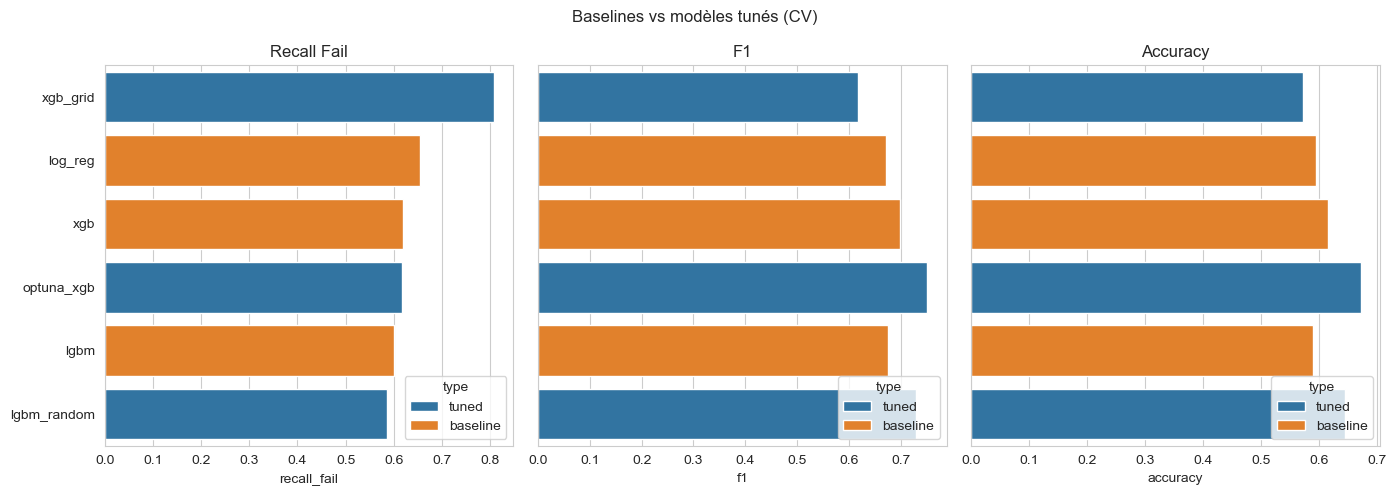

In [12]:
# Visual comparison of tuned vs baseline models
if comparison_df.empty:
    print("Aucune donnée de comparaison disponible : exécutez les cellules précédentes.")
else:
    plot_df = comparison_df.copy()
    plot_df = plot_df.sort_values("recall_fail", ascending=False)
    metrics = ["recall_fail", "f1", "accuracy"]
    fig, axes = plt.subplots(1, len(metrics), figsize=(14, 5), sharey=True)
    for ax, metric in zip(axes, metrics):
        sns.barplot(data=plot_df, x=metric, y="model", hue="type", ax=ax)
        ax.set_title(metric.replace("_", " ").title())
        ax.set_xlabel(metric)
        ax.set_ylabel("")
        ax.legend(title="type", loc="lower right")
    fig.suptitle("Baselines vs modèles tunés (CV)")
    plt.tight_layout()
    plt.show()

## 7. Évaluation sur test + sauvegarde du meilleur modèle
- Sélection du meilleur tuned (rappel_fail CV).
- Refit sur tout le train exam, évaluation sur test, sauvegarde `models/exam_tuned.joblib`.

In [11]:
search_map = {
    "xgb_grid": grid_xgb,
    "lgbm_random": rand_lgbm,
    "optuna_xgb": SimpleNamespace(best_estimator_=optuna_best_estimator),
}

best_row = (
    comparison_df[comparison_df["type"] == "tuned"]
    .sort_values("recall_fail", ascending=False)
    .iloc[0]
)
best_name = best_row["model"]
best_search = search_map[best_name]

best_estimator = best_search.best_estimator_
best_estimator.fit(X_exam, y_exam)

X_test_exam, y_test_exam = exam_split["X_test"], exam_split["y_test"]
test_pred = best_estimator.predict(X_test_exam)
if hasattr(best_estimator, "predict_proba"):
    test_proba = best_estimator.predict_proba(X_test_exam)[:, 1]
    test_auc = roc_auc_score(y_test_exam, test_proba)
else:
    test_proba = None
    test_auc = np.nan

test_metrics = {
    "recall_fail": recall_score(y_test_exam, test_pred, pos_label=0),
    "f1": f1_score(y_test_exam, test_pred),
    "accuracy": accuracy_score(y_test_exam, test_pred),
    "roc_auc": test_auc,
}

report = classification_report(y_test_exam, test_pred, target_names=["fail", "pass"], output_dict=True)

models_dir = Path("..") / "models"
models_dir.mkdir(parents=True, exist_ok=True)
model_path = models_dir / "exam_tuned.joblib"
joblib.dump(best_estimator, model_path)

print(f"Best tuned model: {best_name}")
pd.DataFrame([test_metrics])
pd.DataFrame(report).T
print(f"Model saved to {model_path}")

Best tuned model: xgb_grid
Model saved to ..\models\exam_tuned.joblib


c:\Users\nicol\anaconda3\envs\Data\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:44:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
